In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
def make_batch():
    input_batch = []
    target_batch = []

    for sen in sentences:
        # ex) I like dog
        word = sen.split()  # space tokenizer
        input = [word_dict[n] for n in word[:-1]]   # 앞에 N개의 단어 (I - 3, like - 0)
        target = word_dict[word[-1]]       # 예측할 단어 (dog - 6)

        input_batch.append(input)
        target_batch.append(target)

    return input_batch, target_batch

In [3]:
# Model
class NNLM(nn.Module):
    def __init__(self):
        super(NNLM, self).__init__()
        # nn.Embedding(num_embeddings, embedding_dim)
        self.C = nn.Embedding(n_class, m)    

        # nn.Linear(input_dim, output_dim, bias=T or F(bias 학습 X))
        self.H = nn.Linear(n_step*m, n_hidden, bias=False)  
        self.d = nn.Parameter(torch.ones(n_hidden))

        self.U = nn.Linear(n_hidden, n_class, bias=False)
        self.W = nn.Linear(n_step*m, n_class, bias=False)
        self.b = nn.Parameter(torch.ones(n_class))

    def forward(self, X):   
        # 입력 : [n_step, m]
        # Embedding layer
        X = self.C(X)   # [batch_size, n_step, m]

        # Projection Layer
        X = X.view(-1, n_step*m)    # [batch_size, n_step*m]

        # Hidden Layer
        tanh = torch.tanh(self.d + self.H(X))   # [batch_size, n_hidden]

        # Output Layer
        output = self.b + self.W(X) + self.U(tanh)  # [batch_size, n_class]
        return output



In [5]:
n_step = 2
n_hidden = 2    
m = 2   # embedding_dim

sentences = ["I like dog", "I love coffee", "I hate milk"]

word_list = " ".join(sentences).split()
word_list = list(set(word_list))    # ['like', 'milk', 'coffee', 'I', 'hate', 'love', 'dog']
word_dict = {w:i for i,w in enumerate(word_list)}   # ex) 'like' : 0
number_dict = {i:w for i,w in enumerate(word_list)} # ex) 0 : 'like'
n_class = len(word_dict)    # number of Vocabulary
print('n_class :', n_class)


n_class : 7


In [10]:
# model 선언
model = NNLM()

In [12]:
criterion = nn.CrossEntropyLoss()   # cost function
optimizer = optim.Adam(model.parameters(), lr=0.001)    # 최적화

In [16]:
input_batch, target_batch = make_batch()
print('input_batch :', input_batch)
print('target_batch :', target_batch)

input_batch = torch.LongTensor(input_batch)
target_batch = torch.LongTensor(target_batch)

input_batch : [[3, 0], [3, 5], [3, 4]]
target_batch : [6, 2, 1]


In [17]:
print('After input : {}, target : {}'.format(input_batch.shape, target_batch.shape))

After input : torch.Size([3, 2]), target : torch.Size([3])


In [18]:
# Training
for epoch in range(5000):
    optimizer.zero_grad()
    output = model(input_batch)     # 순전파

    # output : [batch_size, n_class]
    # target : [batch_size]
    loss = criterion(output, target_batch)  # 손실함수
    if (epoch+1)%1000==0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))
    
    loss.backward()     # 역전파
    optimizer.step()    # learning rate만큼 이동

Epoch: 1000 cost = 0.079087
Epoch: 2000 cost = 0.012405
Epoch: 3000 cost = 0.004127
Epoch: 4000 cost = 0.001769
Epoch: 5000 cost = 0.000858


In [25]:
# Predict
predict = model(input_batch).data.max(1, keepdim=True)[1]

In [29]:
print('predict :', predict, ', shape=', predict.shape)

sqz = predict.squeeze()
print('After squeeze() :', sqz, sqz.shape)

print('Tensor ', sqz[0],'의 item : ', sqz[0].item())

predict : tensor([[6],
        [2],
        [1]]) , shape= torch.Size([3, 1])
After squeeze() : tensor([6, 2, 1]) torch.Size([3])
Tensor  tensor(6) 의 item :  6


In [30]:
# Test
print([sen.split()[:2] for sen in sentences], '→', [number_dict[n.item()] for n in predict.squeeze()])

[['I', 'like'], ['I', 'love'], ['I', 'hate']] → ['dog', 'coffee', 'milk']


# Word2Vec

## Skip-Gram

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [62]:
# Model
class Word2Vec(nn.Module):
    def __init__(self):
        super(Word2Vec, self).__init__()
        self.W = nn.Linear(voc_size, embedding_size, bias=False)   
        self.WT = nn.Linear(embedding_size, voc_size, bias=False)
    
    def forward(self, X):
        # X : [batch_size, voc_size]
        hidden_layer = self.W(X)    # hidden_layer : [batch_size, embedding_size]
        output_layer = self.WT(hidden_layer)    # output_layer : [batch_size, voc_size]
        return output_layer

In [63]:
# replace : True(복원추출 - 모든 원소가 뽑힐 확률이 동일함), False(비복원추출)
# np.random.chocie(모집단, size, replace=T or F)
tmp_idx = np.random.choice(range(32), 2, replace=False)
for tmp in tmp_idx:
    print('tmp :', tmp)

tmp : 2
tmp : 5


In [64]:
np.eye(8)[4]

array([0., 0., 0., 0., 1., 0., 0., 0.])

In [65]:
def random_batch():
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(skip_grams)), batch_size, replace=False)      # 0~31(len(skip_grams)) 중 2(batch_size)개를 랜덤으로 뽑음 (겹치치 않음)

    for i in random_index:  
        random_inputs.append(np.eye(voc_size)[skip_grams[i][0]])    # target
        random_labels.append(skip_grams[i][1])  # context word

    return random_inputs, random_labels

In [66]:
batch_size = 2  # mini-batch size
embedding_size = 2  # embedding size
sentences = ["apple banana fruit", "banana orange fruit", "orange banana fruit", "dog cat animal", "cat monkey animal", "monkey dog animal"]

word_sequence = " ".join(sentences).split()
word_list = " ".join(sentences).split()
word_list = list(set(word_list))    # 중복제거
word_dict = {w:i for i,w in enumerate(word_list)}
idx2word = {i:w for i,w in enumerate(word_list)}
voc_size = len(word_list)

In [67]:
print('word dict :', word_dict)
print('vocab size :', voc_size)
print('word sequence :', word_sequence)

word dict : {'fruit': 0, 'apple': 1, 'monkey': 2, 'animal': 3, 'banana': 4, 'dog': 5, 'cat': 6, 'orange': 7}
vocab size : 8
word sequence : ['apple', 'banana', 'fruit', 'banana', 'orange', 'fruit', 'orange', 'banana', 'fruit', 'dog', 'cat', 'animal', 'cat', 'monkey', 'animal', 'monkey', 'dog', 'animal']


In [68]:
# Make skip-gram of one size window
skip_grams = []
for i in range(1, len(word_sequence)-1):
    target = word_dict[word_sequence[i]]
    context = [word_dict[word_sequence[i-1]], word_dict[word_sequence[i+1]]]
    for w in context:
        skip_grams.append([target, w])  # [target, 앞 단어], [target, 뒤 단어]

In [69]:
print('skip_gram :', len(skip_grams))

skip_gram : 32


In [70]:
model = Word2Vec()

criterion = nn.CrossEntropyLoss()   # Cost function
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [71]:
# Training
for epoch in range(5000):
    input_batch, target_batch = random_batch()
    
    input_batch = torch.Tensor(input_batch)
    target_batch = torch.LongTensor(target_batch)

    optimizer.zero_grad()
    output = model(input_batch)

    # output : [batch_size, voc_size]
    # target_batch : [batch_size] (LongTensor, not one-hot)
    loss = criterion(output, target_batch)
    if (epoch+1) % 1000 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))
    
    loss.backward()
    optimizer.step()

Epoch: 1000 cost = 2.029262
Epoch: 2000 cost = 1.532641
Epoch: 3000 cost = 1.231635
Epoch: 4000 cost = 1.488697
Epoch: 5000 cost = 0.712782


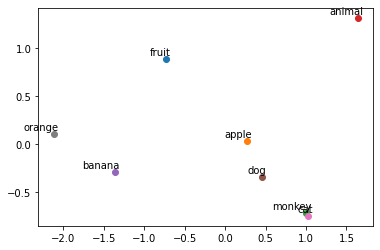

In [72]:
for i,label in enumerate(word_list):
    W,WT = model.parameters()
    x,y = W[0][i].item(), W[1][i].item()
    plt.scatter(x,y)
    plt.annotate(label, xy=(x,y), xytext=(5,2), textcoords='offset points', ha='right', va='bottom')
plt.show()

In [73]:
sample_id = [[word_dict[i] for i in ["banana", "cat"]]]
sample = []
for id in sample_id:
    sample.append(np.eye(voc_size)[id])

sample = torch.Tensor(sample)
sample.shape

torch.Size([1, 2, 8])

In [82]:
output = model(sample)

# output_layer : [batch_size, voc_size]
for i in range(2):
    print('origin : ', idx2word[sample_id[0][i]], end=' -> ')
    target = torch.argmax(output[0][i])
    #print(output[0][i])
    print(idx2word[target.item()])

origin :  banana -> fruit
origin :  cat -> animal
